# Bank Marketing Project 

dataset source: https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('bank_marketing_train.csv', sep=';')
test_df = pd.read_csv('bank_marketing_test.csv', sep=';')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [6]:
test_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


The train file holds 90% of the data and the test file holds the other 10% (they both include the target column, "y"). I think that ratio is a little too high and an 80/20 split would allow for a more thorough test set. Subsequently, I'm going to concatenate these two files and then perform a new train-test split.

In [7]:
rejoined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
rejoined_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Tidying up the datetime columns and performing the train-test-split

Before doing a train-test-split, I'd like to be able to see how the date columns work throughout the year. To that end, I'll convert them to a 'month-day' datetime column, which I can do here before the train-test-split without producing any data leakage.

In [8]:
#Making sure the 'month' column is exhaustive 
rejoined_df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [9]:
#converting the 'month' column to a datetime-conversion-friendly format
month_abbr_to_num = {
    "jan": '01',
    "feb": '02',
    "mar": '03',
    "apr": '04',
    "may": '05',
    "jun": '06',
    "jul": '07',
    "aug": '08',
    "sep": '09',
    "oct": '10',
    "nov": '11',
    "dec": '12',
}
rejoined_df['month'] = rejoined_df['month'].map(month_abbr_to_num)
rejoined_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,05,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,05,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,05,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,05,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,05,198,1,-1,0,unknown,no


In [10]:
#First converting the 'day' column to a string column
rejoined_df['str_day'] = rejoined_df['day'].apply(str)

In [11]:
#Now adding in the leading zeroes before converting to datetime
# since Python wouldn't allow it when they were integers
leading_zeroes_dict = {
    '1': '01',
    '2': '02',
    '3': '03',
    '4': '04',
    '5': '05',
    '6': '06',
    '7': '07',
    '8': '08',
    '9': '09',
}
rejoined_df['str_day'] = rejoined_df['str_day'].map(leading_zeroes_dict).fillna(rejoined_df['str_day'])
#Making sure it worked
rejoined_df['str_day'].unique()

array(['05', '06', '07', '08', '09', '12', '13', '14', '15', '16', '19',
       '20', '21', '23', '26', '27', '28', '29', '30', '02', '03', '04',
       '11', '17', '18', '24', '25', '01', '10', '22', '31'], dtype=object)

In [12]:
#creating a 'month-day' column that will better help keep track of annual trends
rejoined_df['month-day'] = rejoined_df['month'] + rejoined_df['str_day']
rejoined_df['month-day'] = pd.to_datetime(rejoined_df['month-day'], format='%m%d')
rejoined_df['month-day'] = rejoined_df['month-day'].dt.strftime('%m-%d')

#dropping the now-unnecessary 'str_day' column
rejoined_df.drop('str_day', axis=1, inplace=True)

#converting the original 'month' and 'day' columns back into integers:
rejoined_df['month'] = rejoined_df['month'].apply(int)
rejoined_df['day'] = rejoined_df['day'].apply(int)

rejoined_df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month-day
32852,38,technician,married,secondary,no,710,yes,no,cellular,17,4,196,1,346,3,failure,no,04-17
7133,41,admin.,married,secondary,no,3279,yes,no,unknown,29,5,186,1,-1,0,unknown,no,05-29
15977,44,technician,married,secondary,no,196,no,no,cellular,22,7,367,1,-1,0,unknown,no,07-22
19480,48,technician,married,secondary,no,566,no,no,cellular,7,8,51,3,-1,0,unknown,no,08-07
16801,42,blue-collar,married,secondary,no,0,yes,no,cellular,24,7,149,2,-1,0,unknown,no,07-24
2157,44,blue-collar,married,secondary,no,23,yes,no,unknown,12,5,388,2,-1,0,unknown,no,05-12
37060,28,blue-collar,single,secondary,no,53,yes,no,cellular,13,5,93,1,-1,0,unknown,no,05-13
42124,44,technician,married,tertiary,no,1818,yes,yes,cellular,3,11,88,2,83,2,failure,no,11-03
10057,36,blue-collar,married,primary,no,409,yes,no,unknown,11,6,81,3,-1,0,unknown,no,06-11
6065,34,management,single,tertiary,no,72,yes,no,unknown,26,5,118,2,-1,0,unknown,no,05-26


One last change I can make without data leakage would be to turn the target column ("y") values into 0's and 1's (for "no" and "yes", respectively). 

In [13]:
y_column_integer_map = {'no': 0, 'yes': 1}
rejoined_df['y'] = rejoined_df['y'].map(y_column_integer_map)
rejoined_df['y'].value_counts()

0    43922
1     5810
Name: y, dtype: int64

In [14]:
#Now to train-test-split with a larger test size than the original dataset files had
X = rejoined_df.drop('y', axis=1)
y = rejoined_df['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=713)

In [15]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,month-day
22065,51,housemaid,married,primary,no,3486,no,no,cellular,20,8,135,11,-1,0,unknown,08-20
23946,54,blue-collar,married,secondary,no,466,no,no,cellular,29,8,436,4,-1,0,unknown,08-29
14232,35,blue-collar,married,secondary,no,1287,yes,no,cellular,14,7,330,2,-1,0,unknown,07-14
15211,50,blue-collar,married,secondary,no,19,no,no,cellular,17,7,209,4,-1,0,unknown,07-17
24198,34,technician,single,secondary,no,105,yes,no,cellular,17,11,303,1,196,2,failure,11-17


## Understanding each feature

Some columns are self-explanatory, such as 'age', 'job', 'marital' status, 'education' level, best way to 'contact', and the target ('y'). Others are not as straightforward, so let's consult the data dictionary [found with the dataset here](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data):

**basic client information:**
- 'default' shows whether they've defaulted on credit before
- 'balance' refers to the average yearly account balance
- 'housing' (yes/no) shows whether they have a housing loan
- 'loan' (yes/no) shows whether they have a personal loan

**current marketing campaign data:**
- 'day', 'month', and 'duration' refer to the last time the bank contacted the client via phone in terms of the day of the month, the month, and the duration of that last call in seconds. 
- 'campaign' refers to the 'number of contacts performed during this campaign and for this client' and this 'includes the last contact'

**previous campaign data:**
- 'pdays' refers to the 'number of days that passed by after the client was last contacted from a previous campaign' and '-1 means client was not previously contacted'
- 'previous' refers to the 'number of contacts performed before this campaign and for this client'
- 'poutcome' refers to the 'outcome of the previous marketing campaign'

### Let's also examine how these columns' values are distributed. First, the continuous features:

In [16]:
X_train_continuous = X_train[['age', 'balance', 'campaign', 'pdays', 'previous']]

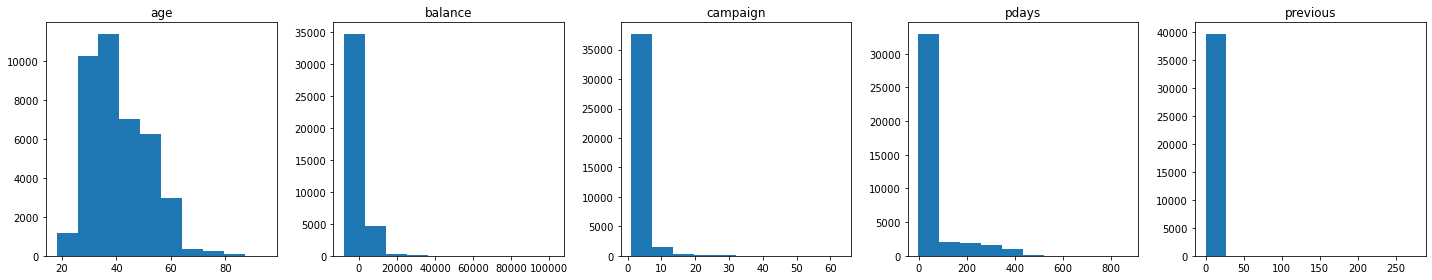

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for index, col in enumerate(X_train_continuous):
    axes[index].hist(X_train_continuous[col])
    axes[index].set_title(X_train_continuous.columns[index])
plt.tight_layout();

Each of these distributions skew left. It turns out that [continuous features do not need to be normally distributed in a classification problem](https://www.sciencedirect.com/topics/nursing-and-health-professions/logistic-regression-analysis#:~:text=Logistic%20regression%20does%20not%20assume,equal%20variance%20within%20each%20group), but nonetheless it is worth noting that all these attributes except for 'age' start on zero and contain a few high outliers. 

Before I examine the categorical columns, the date information is kind of in a grey area. Let's check out how the months look:

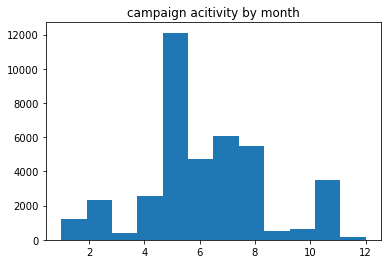

In [18]:
fig, ax = plt.subplots()
ax.hist(X_train['month'], bins=12)
ax.set_title('campaign acitivity by month');

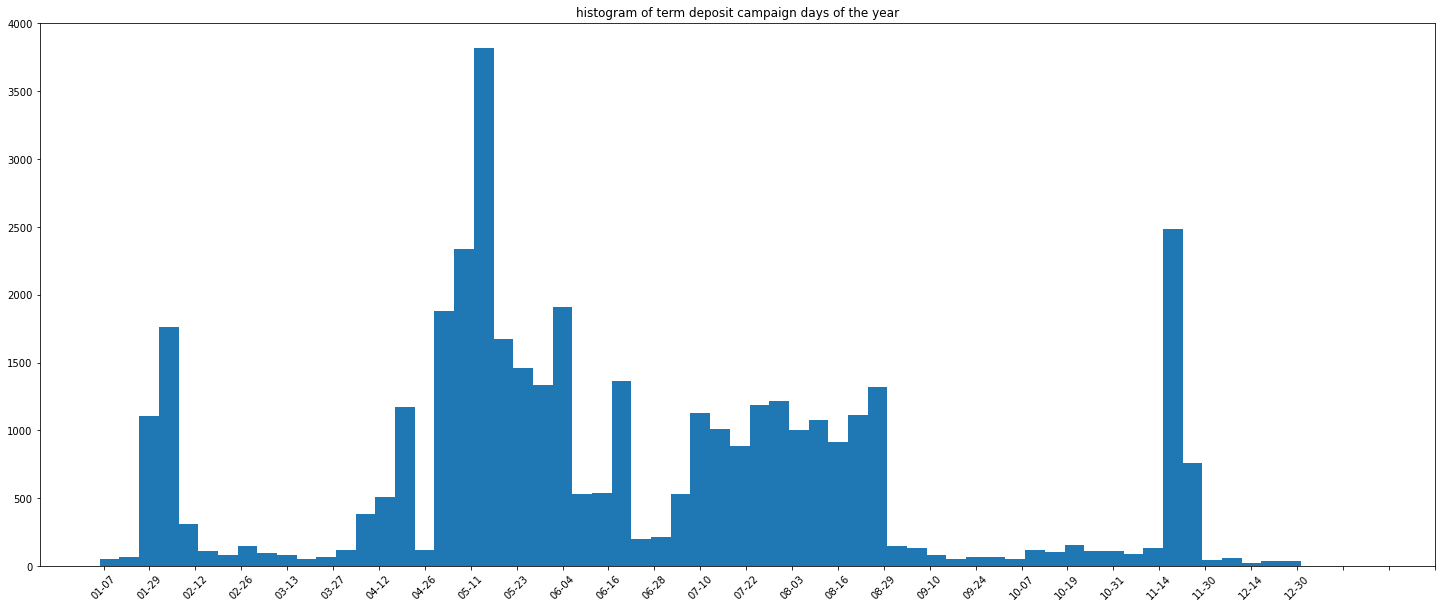

In [19]:
#Have to do a little legwork to resort the 'month-day' column for a histogram
X_train_month_day_sorted = X_train['month-day'].copy()
X_train_month_day_sorted.sort_values(inplace=True)
#Plotting the histogram
x_ticks_range = np.arange(1, 360, 12)
fig, ax = plt.subplots(figsize=(25,10))
ax.hist(X_train_month_day_sorted, bins='auto')
ax.set_title('histogram of term deposit campaign days of the year')
plt.xticks(x_ticks_range, rotation=45);

This is just the months/days of the year for the records in our dataset; not the successful conversion attempt days. Nonetheless, we can see they were a lot more active during the summer with a few spikes along the way in late-January/early-February, April, and then a pretty big one during November.

### Now let's see how the other categorical columns look. 

This graph may be a little hard to read in detail, but for now, I'm just looking to see the general distribution of each column, not the details.

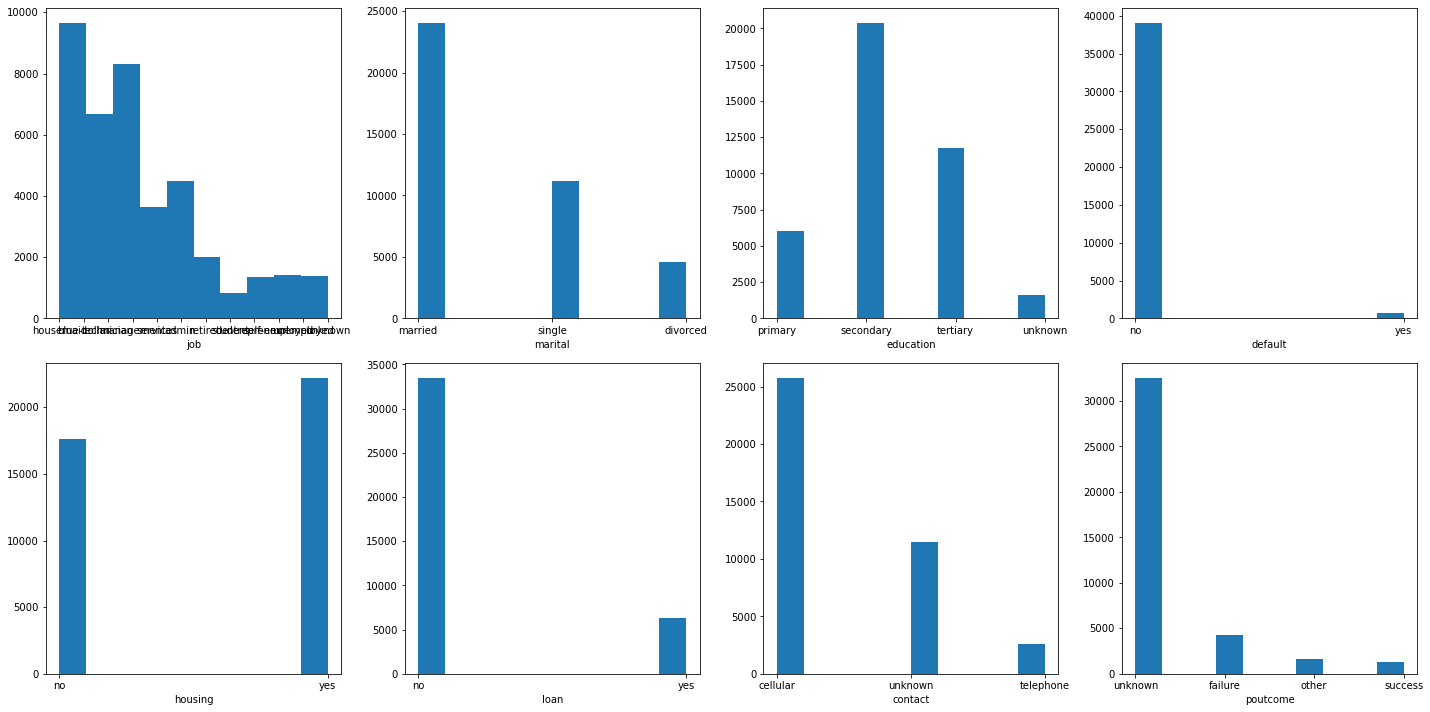

In [20]:
X_train_categorical = X_train[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, column in enumerate(X_train_categorical.columns):
    row = i//4
    col = i%4
    ax = axes[row][col]
#    ax.hist(column, density=True)
#    ax.hist(column, bins='auto')
    ax.hist(X_train[column])
    ax.set_xlabel(column)
plt.tight_layout();

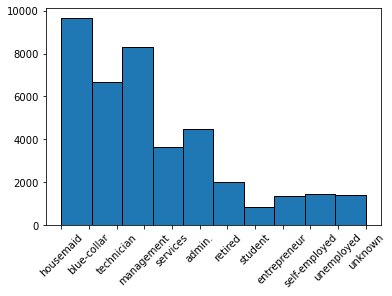

In [21]:
#The job one is hard to see, here it is on its own.
plt.hist(X_train['job'], edgecolor='black')
plt.xticks(rotation=45);

So, when it comes to issue of entropy, it looks like the 'default' and 'loan' columns would make the best case for earlier splits in a decision tree, with 'poutcome' next, then probably 'marital', 'contact', and 'education' won't be too far behind, then 'job' and 'housing' round out the end of the line. Of course, we won't know until we run a decision tree model. 

## establishing a baseline model

I think a decision tree is the best way to go right now and then, if we want to "exceed objectives" later, we can try a scikit-learn or StatsModels classification model later. But ultimately, I don't how else I'd find out which attributes correlate best outside of a decision tree. 

I know decision trees are all about how you set them up, pruning, and hyperparameters. To that end, maybe our "baseline" here is a "vanilla" model where we don't do any of that stuff first.

In [22]:
#Importing everything we'll need for our baseline model
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [23]:
#one-hot encoding the categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(X_train.columns))
#instantiating & fitting the DecisionTreeClassifier model
clf_baseline = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_baseline.fit(X_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=713)

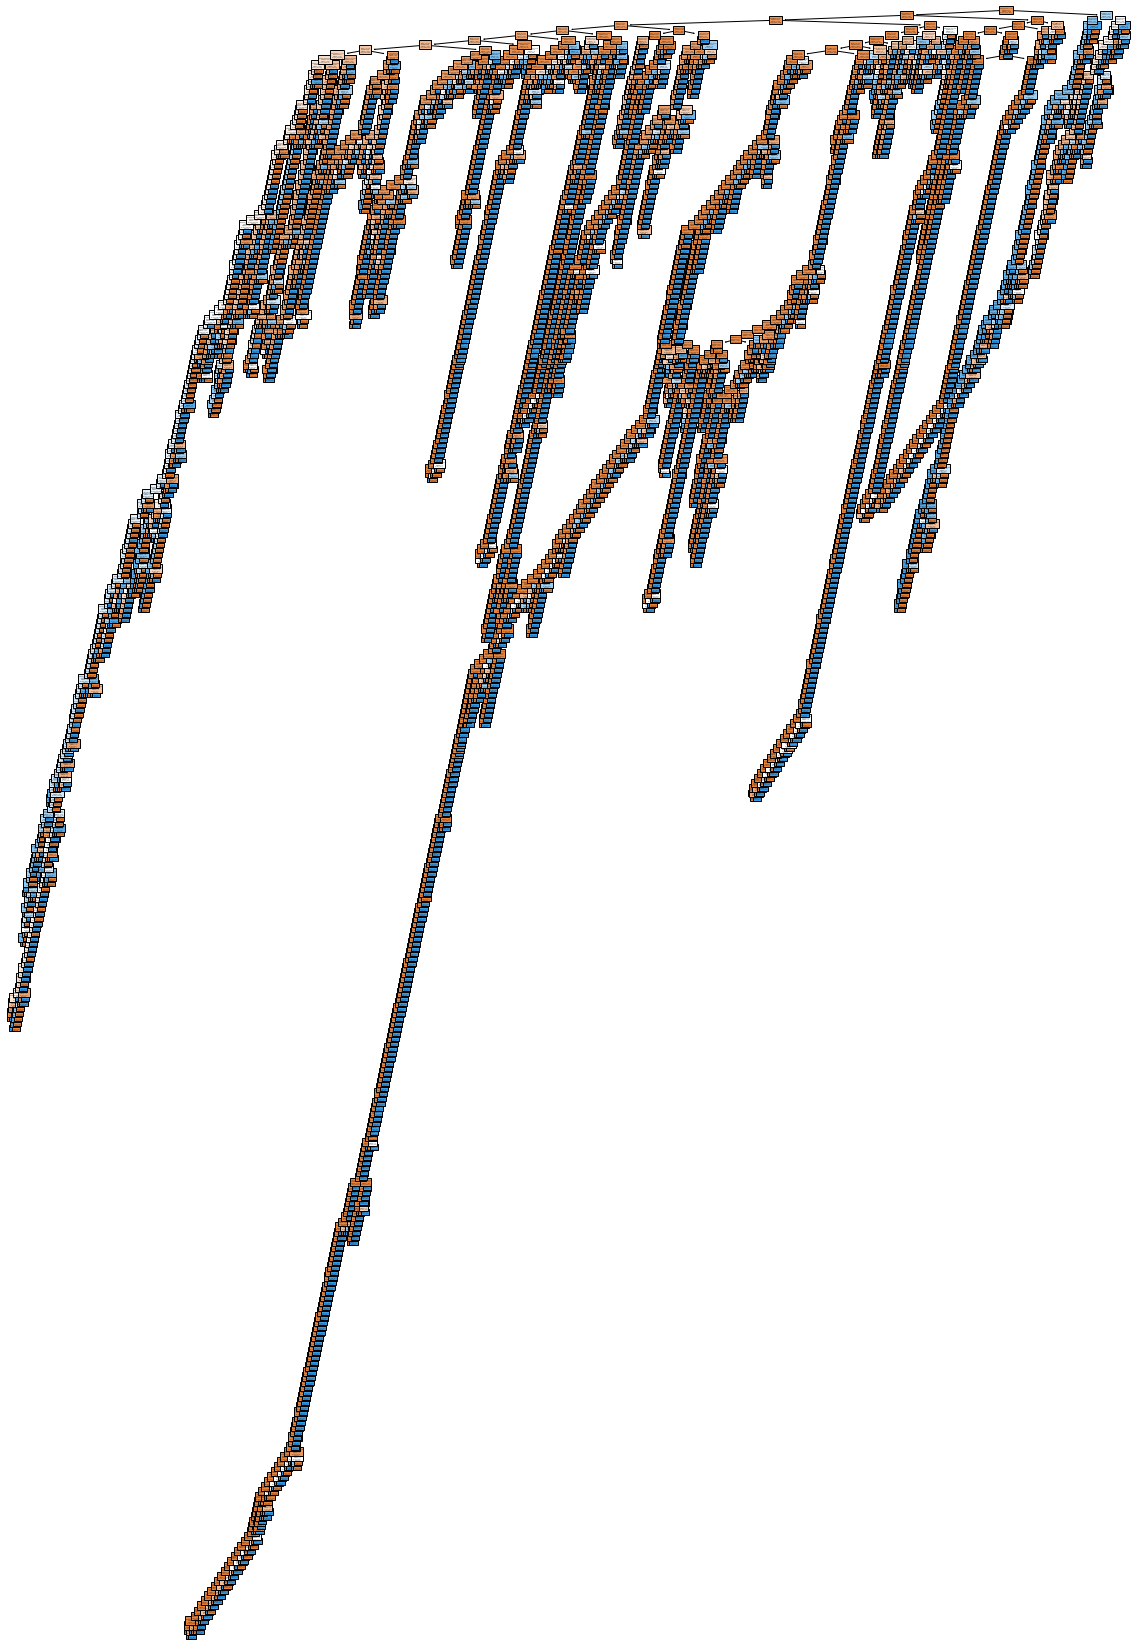

In [24]:
#Checking out the tree plot
fig, ax = plt.subplots(figsize=(20,30))
tree.plot_tree(clf_baseline,
              feature_names = ohe_df.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

In [25]:
#Wow, what a monstrosity. We'll definitely need to prune this tree. 

#Let's evaluate with accuracy for now, just to see and get a feel for what's going on:
#X_test_ohe = ohe.transform(X_test)
#y_pred_test = clf.predict(X_test_ohe)
#print('accuracy:', accuracy_score(y_test, y_pred_test))

#WAIT, I'm not supposed to use accuracy, let's see if we can pin down whether we want 
# to priveldge precision, recall, or both (in which case, we'd employ an F1 score.)

### Evaluating the baseline model

Okay, so next is (1) evaluation metrics (ConfusionMatrices, AUC/ROC, class imbalance, more in my notes) and (2) tree-pruning. I guess the iterative pruning of hyperparameters would take a long time, but it's still feasible.

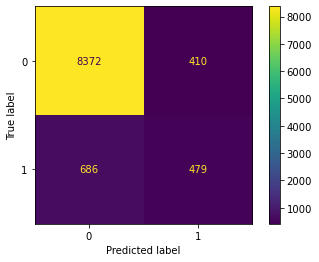

In [45]:
#tranforming X_test with OneHotEncoder and making our y_test predictions
X_test_ohe = ohe.transform(X_test)
y_pred_test = clf_baseline.predict(X_test_ohe)
#importing & building a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test); #8851 / 9947

This reminds me, we need to address the class-imbalance problem. Before we get into that, let's break down this confusion matrix, which shows the model's predictions out from 9,947 test records:

- predicted true positives (bottom right) 479 times (4.8% of all predictions)
- predicted false positives (top right) 410 times (4.1%)
- predicted true negatives (top left) 8,372 times (84.2%)
- predicted false negatives (bottom left) 686 times (6.9%)

So, this model is dealing with somewhat more in the way of false negatives than false positives. **Which is a bigger deal for our stakeholder? Probably false negatives** because they represent current clients who would have made a term deposit, but weren't on the call list given to the hired call center.

False positives probably aren't as big a deal; sure, it's not ideal to have paid the call center to contact those clients who didn't wind up setting an account, but the "wasted" cost for those client calls was likely less than the profit they lose from false positives. All this to say, we want to priveldge **recall** as an evaluation metric here. 

In [25]:
#First I need to make my training set predictions
y_pred_train = clf_baseline.predict(X_train_ohe)
#Now we can proceed with the recall_score
from sklearn.metrics import recall_score
print('train recall:', recall_score(y_train, y_pred_train))
print('test recall:', recall_score(y_test, y_pred_test))

train recall: 1.0
test recall: 0.4111587982832618


In [71]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_test)

0.46640701071080815

That is some serious overfitting and a really bad test recall score. Hopefully our refined models make substantial improvements. Honestly, it wouldn't take much to improve on that, so I wonder whether this vanilla model can even serve as a meaningful baseline. We shall see. For now, let's keep evaluating it and check out the ROC/AUC metric.

In [26]:
#Now we're ready to check the area under curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
print('train AUC:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('test AUC:', auc(fpr, tpr))

train AUC: 1.0
test AUC: 0.6822361971375316


This is just an okay test AUC score; it's definitely better than random guessing, but not by an impressive amount. Again, hopefully pruning our decision tree model and accounting for class imabalance will result in a significant improvement.

In [27]:
#Now we'll do a cross validation score with negative log loss because...we did it in earlier lessons.
from sklearn.model_selection import cross_val_score
#train
baseline_neg_log_loss_cv_train = cross_val_score(clf_baseline, X_train_ohe, y_train, scoring='neg_log_loss')
baseline_log_loss_train= -(baseline_neg_log_loss_cv_train.mean())
print('training log loss score:', baseline_log_loss_train)
#test
baseline_neg_log_loss_cv_test = cross_val_score(clf_baseline, X_test_ohe, y_test, scoring='neg_log_loss')
baseline_log_loss_test = -(baseline_neg_log_loss_cv_test.mean())
print('testing log loss score:', baseline_log_loss_test)

training log loss score: 4.010688791092663
testing log loss score: 4.765042535180511


This is not as interpetable as the other metrics yet, but it will be once we start refining and reevaluating later models. 

### Next steps 

Class imbalance and tree pruning on this model. Afterwards, it's trying the whole thing again with a LogisticRegression model. 

## Addressing target class imbalance

We've learned about the class_weight hyperparameter, but that's for LogisticRegression models, so we'll run that later when we do a second model attempt. Actually, when you finish with the decision tree stuff and do LogisticRegression, go to the Logistic Regression - Cumulative Lab from Topic 26 and do that stuff. 

I'm realizing that class imbalance in decision trees hasn't been discussed yet, just in LogisticRegression. Nonetheless, there *is* a class_weight param for the DecisionTreeCladsifier model, too. What I still don't understand is how to apply the over & under-sampling by percentage technique that Mark discussed to a decision tree.

In [39]:
clf_balanced_class = DecisionTreeClassifier(criterion='entropy', random_state=713, class_weight="balanced")
clf_balanced_class.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=713)

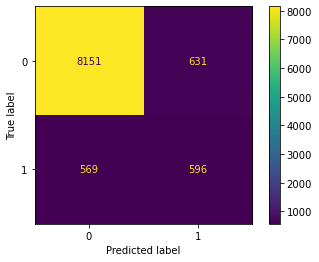

In [40]:
y_pred_test = clf_balanced_class.predict(X_test_ohe)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

The class_weight = 'balanced' model:

- predicted true positives (bottom right) 596 times (6% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 631 times (6.3%, baseline was 4.1%)
- predicted true negatives (top left) 8,151 times (82%, baseline was 84.2%)
- predicted false negatives (bottom left) 569 times (5.7%, baseline was 6.9%)

So, this model predicted more true positives than the baseline, but also more false ones. Of course, that means it wasn't quite as good at predicting true negatives, but it was better at false negatives. This is a mixed bag improvement-wise, but it does bode well for an improvement in the recall score, which we are more concerned with in this case. Let's check to be sure:

In [32]:
print('recall:', recall_score(y_test, y_pred_test))

recall: 0.511587982832618


In [ ]:
f1_score(y_test, y_pred_test)

I think this is a decent, but still somewhat modest improvement over the baseline score of 0.4111587982832618. Let's keep checking evaluation metrics and do the AUC: 

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('AUC:', auc(fpr, tpr))

AUC: 0.7198682341856099


Another small improvement over the baseline's 0.6822361971375316. There's definitely more to improve upon here, but we're on our way. Let's finally check the cross-validated loss score:

In [34]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class, X_test_ohe, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

5.8701768942159855

This is also an improvement over the baseline's 4.765042535180511 score. 

### Further improvement of the class imbalance problem

So far, we found some modest improvement with the 'balanced' class_weight parameter, but I still need to further tweak it. I'm not sure how, though. Can I use SMOTE here? [The docs also mention a dictionary of class weights to run](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), do I run different dictionaries with SMOTE like we did in that one cumulative lab? 

In [35]:
import imblearn
print(imblearn.__version__)

0.11.0


Oversampling and undersampling has not yet been covered in the curriciulum outside of SMOTE, so I found a helpful resourcse [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and am going to practice a bit below using some of the code snippets from that site.

In [49]:
len(X_train_ohe), len(y_train)

(39785, 39785)

In [50]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

Ok, so we have what we expect here, 80% of the total 49k dataset records in X & y train. We also see how y_train has a 87/13% no/yes split. 

Now we're going to see what happens when we use and playa round with imblearn's RandomOverSampler tool:

In [56]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_ohe_over, y_train_over = oversample.fit_resample(X_train_ohe, y_train)
#How does y_over look now?
y_over.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [57]:
len(y_train)/len(y_train_over)

0.5660927717700626

Ok, y_over is not only completely balanced, but also a *lot* bigger than it used to be. What's X_train like?

In [58]:
len(X_train_ohe_over)

70280

In [59]:
len(X_train_ohe)/len(X_train_ohe_over)

0.5660927717700626

Wow, X_over is a lot bigger thank X_train_ohe (and by the same amount as y_over is than y_train). So, X_over & y_over are a synthetic training dataset that may or may not result in better results. If I had to guess, I'd bet the training scores will still be way overfit and the test scores will because we oversampled too much here at the outset, but let's see. 

In [60]:
#fit the model to X_over & y_over
clf_oversample_minority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_oversample_minority.fit(X_train_ohe_over, y_train_over)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [61]:
#make predictions for our evaluation metrics
#Remember, we can't do any oversampling with the test set
y_pred_test_over = clf_oversample_minority.predict(X_test_ohe)

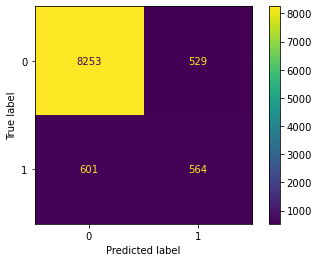

In [62]:
#confusion matrix for this new oversampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

The oversampling with RandomOverSampler(sampling_strategy='minority') model:

- predicted true positives (bottom right) 564 times (5.7% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 529 times (5.3%, baseline was 4.1%)
- predicted true negatives (top left) 8,253 times (83%, baseline was 84.2%)
- predicted false negatives (bottom left) 601 times (6%, baseline was 6.9%)

To review, our last model (class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

So that means both newer models are better than the baseline (not a surprise), but the earlier class_weight = 'balanced' was better than this latest one. That makes sense when I think about how RandomOverSampler(sampling_strategy='minority') introduced a lot of noise into the training data; the resulting X_train_ohe_over and y_train_over datasets were a lot larger.

Subsequently, we can try oversampling to more subtle degrees and see whether our models improve. Before doing that, let's keep looking at our ohter metrics to see how this latest model performed.

In [63]:
#recall scores
#We can't do a train score here because y_train and y_train_over are different sizes
print('recall:', recall_score(y_test, y_pred_test_over))

recall: 0.48412017167381977


Like with our confusion matrix results, this is an improvement over the baseline score of 0.4111587982832618, but not as good as the class_weight = 'balanced' model's 0.511587982832618.

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
print("oversampling = 'minority' AUC:", auc(fpr, tpr))

oversampling = 'minority' AUC: 0.7119416617877183


This is actually worse than the baseline's 0.7198682341856099, which was the same as the class_weight = 'balanced' model.

### Iterating through more subtle oversampling parameters

I know that the maximum we should really try to oversample to is half the size of the classes, so let's try iterating through several more subtle sample_strategy params and see whether we can find a better result along the way and OH SNAP this results in an error saying it can't allocate enough memory to this task. Maybe I'm going the wrong direction 0.5 up to 0.9 and it's supposed to be 0.5 down to 0.1? Let's try just 0.5 and 0.6 and see if it can handle that first.

In [78]:
recall_scores = []
auc_scores = []

sampling_strategies = [0.5, 0.6]
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=i)
    # fit and apply the transform
    X_train_ohe_over, y_train_over = oversample.fit_resample(X_train_ohe, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_float.fit(X_train_ohe_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_float.predict(X_test_ohe)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for RandomOverSampler sampling_strategies 0.5 through 0.6")
print("recall scores:", recall_scores)
print("auc_scores:", auc_scores)

Recall & AUC scores for RandomOverSampler sampling_strategies 0.5 through 0.6
recall scores: [0.4412017167381974, 0.4575107296137339]
auc_scores: [0.6966883099746556, 0.7048997510514582]


Both are worse than the baseline. Now let's do 0.7-0.9:

In [79]:
recall_scores = []
auc_scores = []

sampling_strategies = [0.7, 0.8, 0.9]
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=i)
    # fit and apply the transform
    X_train_ohe_over, y_train_over = oversample.fit_resample(X_train_ohe, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_float.fit(X_train_ohe_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_float.predict(X_test_ohe)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for RandomOverSampler sampling_strategies 0.7 through 0.9")
print("recall scores:", recall_scores)
print("auc_scores:", auc_scores)

Recall & AUC scores for RandomOverSampler sampling_strategies 0.7 through 0.9
recall scores: [0.46008583690987126, 0.46180257510729616, 0.4832618025751073]
auc_scores: [0.7045362001675295, 0.7035157261781072, 0.7121387582677405]


Huh, these are returning the same scores that sampling_strategy = 'minority' returned. Looking at the imblearn docs [here](https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html), maybe I should try a dictionary where the keys are the classes (in this case - like so many others - the classes are 0 and 1) and the values are the exact number of samples I want for each class.

The training data has class 0 ("no") at 35,140 samples and class 1 ("yes") at 4,645. Let's construct dictionaries that can specify the sample sizes as the above attempt would have done and then feed that into our DecisionTreeClassifier models.

You know, maybe I was doing something wrong before and thinking about oversampling the wrong way. When I start making the dictionaries below, I realized (1) you don't touch X_train with OVERsampling, you just adjust y_trian (of course). I don't think what I was doing involved X_train, though, I'm just finally realizing this. Also, I realized (2) I may have been going the wrong way with oversampling sampling_strategy inputs. I'm only supposed to go as high as 150%, so the following dictionaries for our next iteration attempt will reflect 150% oversampling down to 110%, moving in 10% increments (so 150%, 140%, 130%, 120%, and 110%):

In [74]:
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [77]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=i)
    # fit and apply the transform
    X_train_ohe_over, y_train_over = oversample.fit_resample(X_train_ohe, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_float.fit(X_train_ohe_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_float.predict(X_test_ohe)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 1.5 through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 1.5 through 1.1 sample_strategy dictionaries:
recall scores: [0.4051502145922747, 0.4240343347639485, 0.384549356223176, 0.4094420600858369, 0.40858369098712444]
auc_scores:    [0.6794027092091413, 0.6894710503243563, 0.6709241884736924, 0.6841106907124698, 0.6831690944118042]


Wow, oversampling worsens the model. I *could* try running log loss scores on these, even if it'd take forever, but I wonder whether that matters when recall is important to this stakeholder.

Time to move on to:

1. undersampling
2. combining under & over sampling
3. SMOTE

Hopefully, that takes care of our imbalance problem. Next, I need to tune the decision tree hyperparameters. Finally, I need to do it all again with a LogisticRegression model. 

In [88]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_ohe_under, y_train_under = undersample.fit_resample(X_train_ohe, y_train)
len(X_train_ohe_under), len(y_train_under)

(9290, 9290)

In [89]:
len(X_train), len(y_train)

(39785, 39785)

In [90]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

So X and y_under are now 23.17% of their original size. But 1's are 13.21% of 0's. OH WAIT 9,290 is the length of y_train's minority class times two. Also sampling_strategy='majority' was only supposed to touch the majority class and ope...I'm confusing majority/minority with X_train and y_train. Man, what an idiot. Okay, so let's look at this:

In [91]:
y_under.value_counts()

0    4645
1    4645
Name: y, dtype: int64

Okay, so it "balanced" y_train's classes and X_train is the same size as y_train now. I get it. Now let's fit them to a clf and see what happens:

In [93]:
clf_undersampled_majority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_undersampled_majority.fit(X_train_ohe_under, y_train_under)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [94]:
#make predictions for the undersampling model
y_pred_test_under = clf_undersampled_majority.predict(X_test_ohe)

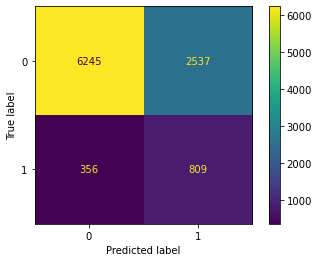

In [96]:
#confusion matrix for this undersampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_under);

In [97]:
len(y_test)

9947

The undersampling with RandomUnderSampler(sampling_strategy='majority') model:

- predicted true positives (bottom right) 809 times (8.1% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 2,537 times (at a whopping 25.5%! The baseline was 4.1%; this model is unusable.)
- predicted true negatives (top left) 6,245 times (62.6%, baseline was 84.2%)
- predicted false negatives (bottom left) 356 times (3.6%, baseline was 6.9%)

To review, our last best model (no over/under sampling, just class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

Unfortunately, we haven't seen an improvement over our baseline but once so far, but we're also just starting with undersampling; let's attempt to refine training data undersampling ratios and see if we improve from here. Below, I layout undersampling strategies for less drastic ratios: 90%, 80%, 70%, 60%, and 50% of the majority, then iterate through them to see if we find an improved model.

In [98]:
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [99]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(sampling_strategy=i)
    # fit and apply the transform
    X_train_ohe_under, y_train_under = undersample.fit_resample(X_train_ohe, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_undersample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_undersample_float.fit(X_train_ohe_under, y_train_under)
    #make predictions for our evaluation metrics
    y_pred_test_under = clf_undersample_float.predict(X_test_ohe)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_under))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.41545064377682406, 0.4369098712446352, 0.45236051502145924, 0.4669527896995708, 0.5150214592274678]
auc_scores:    [0.6826171460742467, 0.6930620866129802, 0.6977129379935354, 0.7013083237953559, 0.7165177895089742]


None of these scores outperform the baseline except the recall score when undersampling is set to fifty percent of the majority. In other words, neither over or under-sampling has really improved on the baseline. I suppose the only left to try is SMOTE:

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=713)
X_train_ohe_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train)
y_train_smote.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [30]:
clf_smote = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_smote.fit(X_train_ohe_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [31]:
y_pred_test_smote = clf_smote.predict(X_test_ohe)

In [32]:
len(y_test)

9947

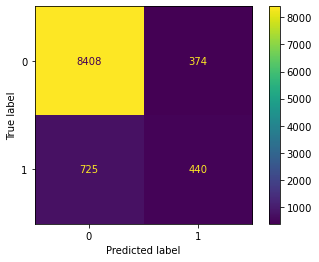

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote);

This SMOTE model:

- predicted true positives (bottom right) 440 times (4.4% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 374 times (3.8%, the baseline was 4.1%)
- predicted true negatives (top left) 8,408 times (85%, baseline was 84.2%)
- predicted false negatives (bottom left) 725 times (7.3%, baseline was 6.9%)

To review, our last best model (no over/under sampling, just a decision tree classifier with class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

This is a mixed bag, SMOTE wasn't as good as our baseline at true positives and false negatives, but it did improve on false positives and true negatives. However, each measure only worsened or improved somewhat slightly. 

When it comes to our only other improvement on the baseline (the DecisionTree with no over/under sampling, just class_weight = 'balanced'), SMOTE did substantially better with false positives & false negatives, but not as well on true positives & negatives. 

If our primary concern is recall, then false negatives are a big deal, and the first improved model (DecisionTree with no over/under sampling, just class_weight = 'balanced') has performed best there. 

Maybe we can try a model that's fed SMOTE-ed training data, but the DecisionTreeClassifier param is set to class_weight = 'balanced'? Oh and don't forget to run the other eval metrics on this current SMOTE model, genius.

In [34]:
print("SMOTE recall score:", recall_score(y_test, y_pred_test_smote))

SMOTE recall score: 0.3776824034334764


Jesus Christ. Okay what about AUC?

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_smote)
print("SMOTE AUC:", auc(fpr, tpr))

SMOTE AUC: 0.6675476467178769


Still worse than the baseline, let's just move on. 

In [36]:
clf_smote_and_balanced = DecisionTreeClassifier(criterion='entropy', random_state=713, class_weight="balanced")
clf_smote_and_balanced.fit(X_train_ohe_smote, y_train_smote)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=713)

In [37]:
y_pred_test_smote_and_balanced = clf_smote_and_balanced.predict(X_test_ohe)

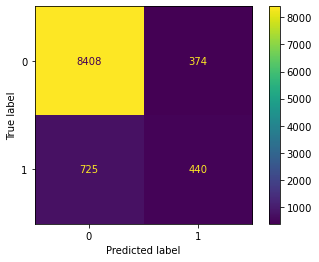

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote_and_balanced);

Ok, I had a feeling this would be redundant, it's the same as the SMOTE model. At least we know! Okay, at this point, I have done all I can for over and under-sampling and it's time to move on to pruning the decision tree. 

Our best model is the clf_balanced_class one, which takes in a "vanilla", non-pre-over-nor-under-sampled X_train_ohe & y_train, and is just a DecisionTreeClassifier with class_weight="balanced", so it *does* address class imbalance with balanced weights "inversely proportional to class frequencies".

## Decision Tree Pruning

Next, we'll see whether tuning the model's 'max_depth', 'min_samples_split', and 'min_samples_leaf' hyperparameters help improve results. If they don't, so help me God, I am so tired of working hard and having nothing to show for it. 

First, let's bring back the evaluation metrics for our best model:

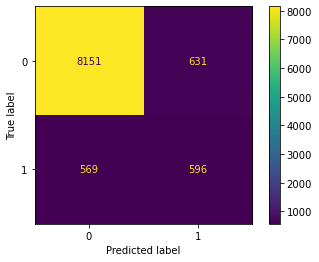

In [41]:
y_pred_test = clf_balanced_class.predict(X_test_ohe)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [42]:
print('recall:', recall_score(y_test, y_pred_test))

recall: 0.511587982832618


In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('AUC:', auc(fpr, tpr))

AUC: 0.7198682341856099


In [44]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class, X_test_ohe, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

5.8701768942159855

Great stuff, now let's try iterating through various modes for the model's 'max_depth' hyperparameter first:

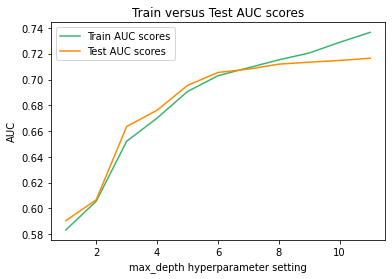

In [46]:
#Let's try up to 12 for now since it takes a minute for my laptop to run just one model
max_depth = np.arange(1,13)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in max_depth:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion="entropy", 
                                      random_state=713, 
                                      class_weight="balanced",
                                      max_depth=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(max_depth, train_auc_values, color='mediumseagreen', label='Train AUC scores')
ax.plot(max_depth, test_auc_values, color='darkorange', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('max_depth hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(3, ymin=0.70, ymax=0.935, color='k', linestyle='--', label="my best guess")
ax.legend();

Nice, it looks like the test scores are starting to even out, but they're still on the rise. Let's adjust our max_depth range to, say, 6 through 20:

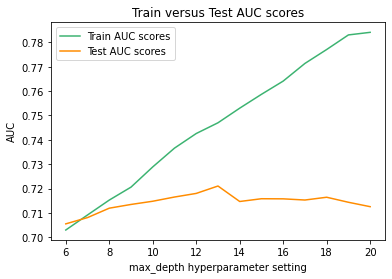

In [47]:
max_depth = np.arange(6,21)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in max_depth:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion="entropy", 
                                      random_state=713, 
                                      class_weight="balanced",
                                      max_depth=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(max_depth, train_auc_values, color='mediumseagreen', label='Train AUC scores')
ax.plot(max_depth, test_auc_values, color='darkorange', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('max_depth hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(3, ymin=0.70, ymax=0.935, color='k', linestyle='--', label="my best guess")
ax.legend();

Alright, we have an optimal max_depth setting of 13, which results in an AUC of around 0.72. That's pretty close to our current model's AUC, so let's see exactly what that is:

In [51]:
max(test_auc_values)

0.7210239340516058

Good news, that's the best AUC so far, even if it's just a little better than the current model's AUC of 0.7199. Before refining more hyperparams, let's stop for a second and evaluate this model with max_depth=13 in regards to recall & neg_log_loss:

In [52]:
clf_balanced_class_md_13 = DecisionTreeClassifier(criterion='entropy', 
                                                  random_state=713, 
                                                  class_weight="balanced", 
                                                  max_depth=13)
clf_balanced_class_md_13.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, random_state=713)

In [68]:
y_pred_test_bcmd13 = clf_balanced_class_md_13.predict(X_test_ohe)
recall_score(y_test, y_pred_test_bcmd13)

0.5407725321888412

In [72]:
f1_score(y_test, y_pred_test_bcmd13)

0.473328324567994

That's the best recall score we've seen so far. Yes, it *is* a slight nudge upward, but still a bigger improvement over 0.5115 than we've seen so far. What about log_loss?

In [55]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class_md_13, X_test_ohe, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

1.314097115635142

Wow, that's a lot better than the non-max-depth-optimized score of 5.87! Okay, now let's move on to tuning the 'min_samples_splits' hyperparam.

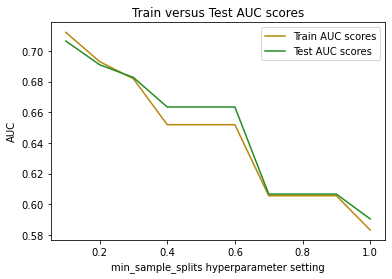

In [56]:
#I think we do this ratio with floats, at least at first
min_samples_split = np.arange(0.1,1.1,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_split:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      class_weight="balanced",
                                      min_samples_split=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_split, train_auc_values, color='darkgoldenrod', label='Train AUC scores')
ax.plot(min_samples_split, test_auc_values, color='forestgreen', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_sample_splits hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.7, ymin=0.70, ymax=0.93, color='k', linestyle='--', label="my best guess")
ax.legend();

This doesn't help, so let's try adjusting 'min_samples_leaf' 

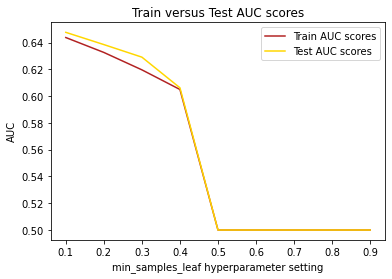

In [57]:
# Calculate the optimal value for minimum sample leafs
min_samples_leaf = np.arange(0.1,1.0,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_leaf:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      class_weight="balanced",
                                      min_samples_leaf=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_leaf, train_auc_values, color='firebrick', label='Train AUC scores')
ax.plot(min_samples_leaf, test_auc_values, color='gold', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_samples_leaf hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.2, ymin=0.5, ymax=0.8, color='k', linestyle='--', label="my best guess")
ax.legend();

Ok...tuning 'min_sample_leaf' along with 'min_samples_split' only worsens the model, so there we have it: **clf_balanced_class_md_13 is the best decision tree model**. One thing we haven't done yet is investigate its Confusion Matrix:

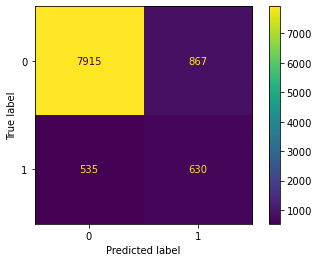

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_bcmd13);

This decision tree with *class_weight = 'balanced'* and *max_depth = 13* model:

- predicted true positives (bottom right) 630 times (6.3% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 867 times (8.7%, the baseline was 4.1%)
- predicted true negatives (top left) 7,915 times (80%, baseline was 84.2%)
- predicted false negatives (bottom left) 535 times (5.4%, baseline was 6.9%)

To review, our last best model (no over/under sampling, just a decision tree classifier with class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

So, adding in the max_depth=13 param may have improved the recall, AUC, and log_loss scores as well as increasing true positives, but it also increased the number of false positives *and* negatives while decreasing the number of true negatives. 

I think this means that the max_depth = 13 model is a better model overall, especially when you consider its recall, AUC, and log-loss scores. However, it does result in 34 more false negatives, but then again, it results in 34 more true positives, so that cancels out. Oh wait, I think that's a redundant observation, like that's just the nature of confusion matrices. 

Next, max_depth = 13 will result in 236 more false positives, which means more wasted money on the call center...so **I think setting max_depth = 13 means 34 fewer missed-out-on term deposits at the expense of 236 more wasted calls.** Is that worth it? I guess it's up to the stakeholder to know, since they'd have more info on what a term deposit would net them as opposed to paying for 236 unsuccessful calls. 

Next steps: 

1. Did I run those 'min_sample_leaf' along with 'min_samples_split' hyperparam nodes correctly? I think they work fine as floats because they're proportions as opposed to ints as exact numbers of leaves/splits.
2. What are the params of this dccwbmd13 model? Is that a thing? <----no, it is not.
3. Am I interpreting the recall and AUC scores a little too broadly? They are relative metrics that depend on the nature of the data.
4. LogisticRegression model

In [62]:
clf_balanced_class_md_13.classes_

array([0, 1], dtype=int64)

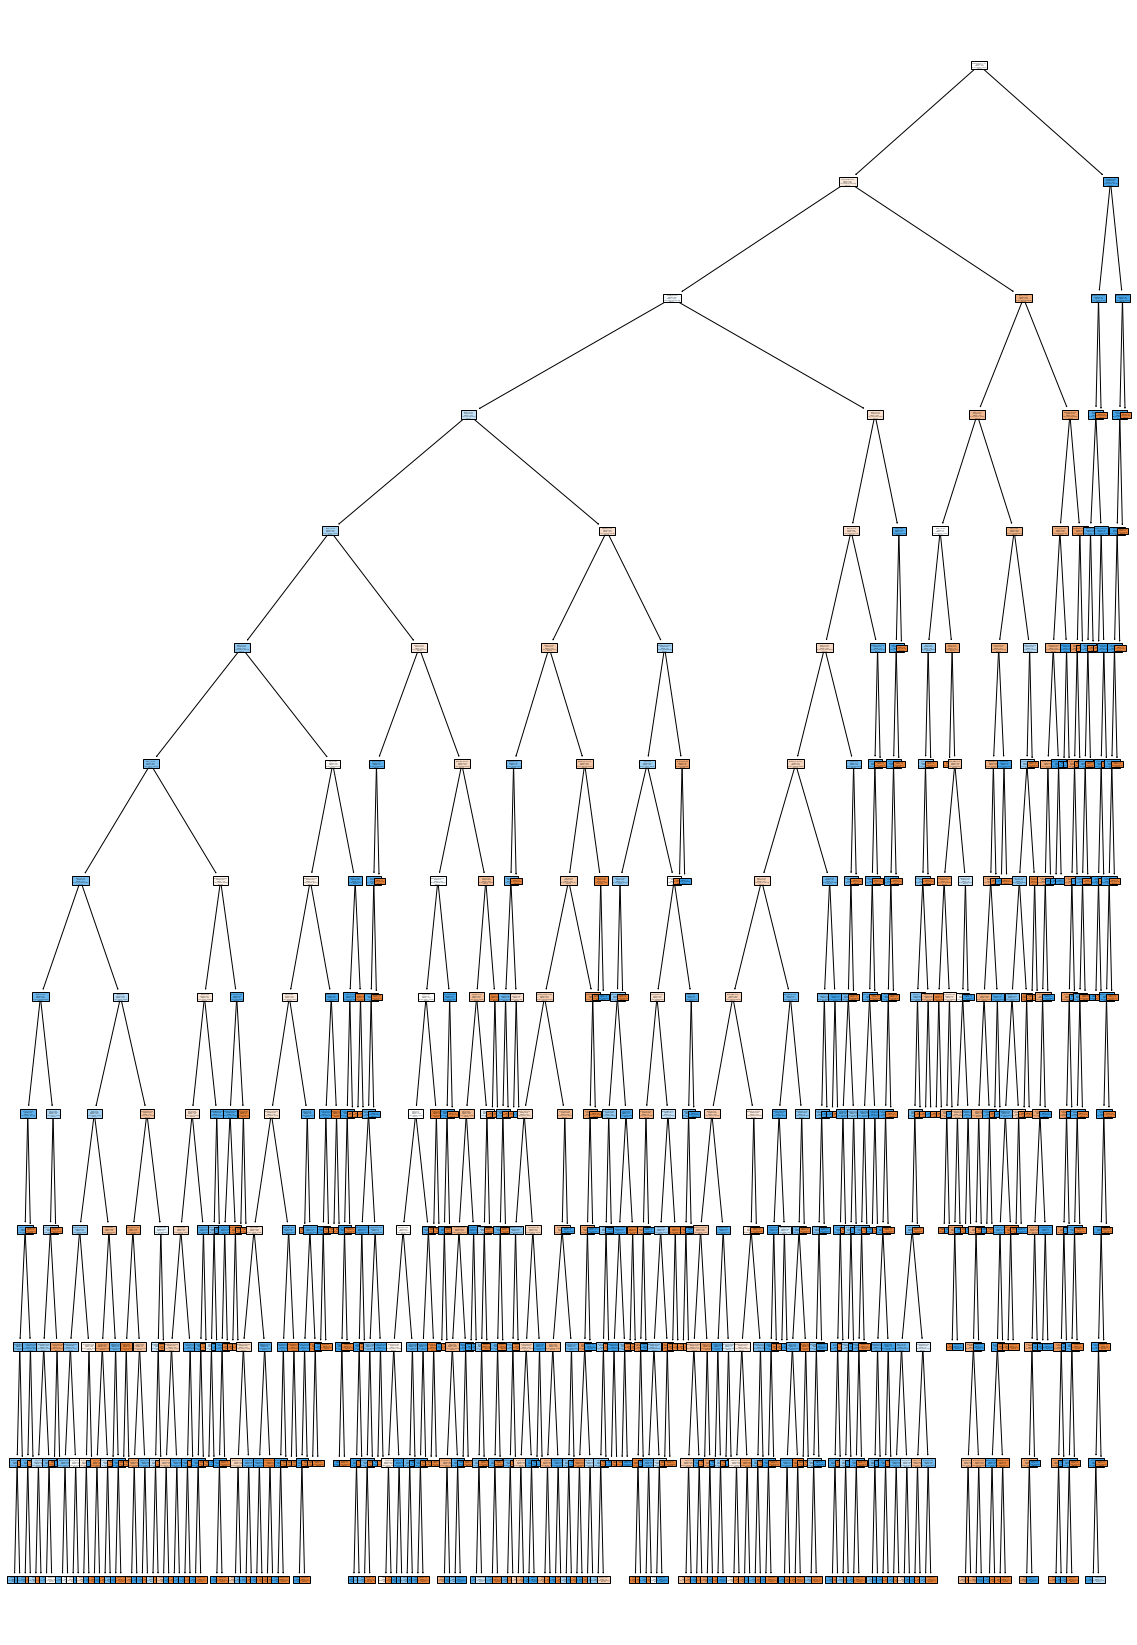

In [78]:
#Checking out the tree plot
fig, ax = plt.subplots(figsize=(20,30))
tree.plot_tree(clf_balanced_class_md_13,
              feature_names = ohe_df.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

Well, that looks a lot more reasonable than the leviathan horror we saw in the baseline model's tree plot. This is still not easy to interpret, but we're focused on predictions here, not necessarily a thorough understanding of how the model explains the data. 

So, with AUC at 0.721, recall at 0.541, and log-loss at 1.314 (which we can only interpret in relation to the baseline's 5.87), the 34 more term deposits versus 236 more wasted calls argument is backed by a "somewhere between okay and good" model. The AUC score is "good", the recall score is just passable, and the log-loss reduction means we made some substantial progress over the baseline. 

**You know, one other thing I need to be able to say is "these are the attributes you should consider if gaining 34 term deposits is worth paying for 236 wasted calls". How do I find that information? Or do I not because it's too large and they simply run this model on new clients?**

In [79]:
y_pred_test_bcmd13

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
clf_balanced_class_md_13.feature_importances_

array([0.        , 0.00031515, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [75]:
feature_importances = pd.DataFrame(clf_balanced_class_md_13.feature_importances_)
feature_importances

,0
0,0.000000
1,0.000315
2,0.000000
3,0.000000
4,0.000000
...,...
9253,0.000000
9254,0.000000
9255,0.000000
9256,0.000000


Our next step is to try all this again with a LogisticRegression model. I hope the evaluation metrics can be the same.